# EMRI Waveforms in Fourier Domain
Here we show how the plots of the paper have been produced

In [1]:
import sys, time, h5py,os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import corner

import matplotlib as mpl

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean

mpl.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "figure.figsize": [default_width, default_width * default_ratio],
})

## Import results

In [2]:
# fontsize label
fs_lab = 18
# legend
fs_leg = 14
# ticks
fs_ticks = 14

## Posterior comparison

In [3]:
from eryn.backends import HDFBackend
import h5py, glob

In [8]:

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def get_autocorr_plot(to_check):
    n_dim  = to_check.shape[-1]
    plt.figure()
    for var in range(n_dim):
        y = to_check[:,:,var].T
        # Compute the estimators for a few different chain lengths
        N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = autocorr_gw2010(y[:, :n])
            new[i] = autocorr_new(y[:, :n])

        # Plot the comparisons
        # plt.loglog(N, gw2010, "o-", label="G&W 2010")
        plt.loglog(N, new, "o-", label=f"new var{var}")

    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    # plt.axhline(true_tau, color="k", label="truth", zorder=-100)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14);
    plt.show()



In [40]:
datasets = sorted(glob.glob('results*/*.h5'))
print(datasets)
pars_inj = sorted(glob.glob('results*/*.npy'))
print(pars_inj)

['results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1.h5', 'results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5', 'results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5']
['results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy', 'results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy', 'results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy']


In [41]:
datasets

['results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1.h5',
 'results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5',
 'results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5']

In [42]:
pars_inj

['results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy',
 'results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy',
 'results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1_injected_pars.npy']

results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.13775949, 0.1459868 , 0.12929303, 0.11274275, 0.14770879,
        0.14254281, 0.13871616, 0.12742753, 0.00162633, 0.13895532,
        0.12355305, 0.12924519, 0.13570267, 0.12379221, 0.14904812,
        0.12230938, 0.13115852, 0.12364871, 0.10312829, 0.12216589,
        0.10733761, 0.13512867, 0.11173826, 0.13111069, 0.12991486,
        0.14397781, 0.13790299, 0.13383718, 0.13670717, 0.13450684,
        0.12254855, 0.14187315]])}}


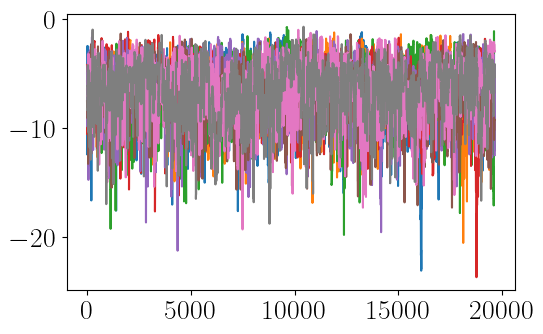

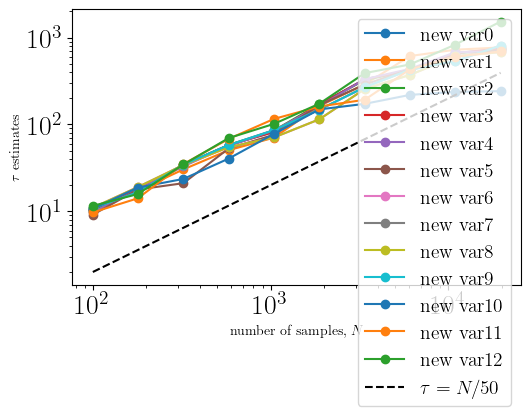

results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.12709337, 0.14562973, 0.12782748, 0.13677449, 0.13223216,
        0.11975224, 0.13356274, 0.13865565, 0.00270704, 0.14911677,
        0.14429915, 0.11332875, 0.11153934, 0.12787337, 0.13246157,
        0.13645331, 0.13883918, 0.11906401, 0.12741454, 0.14342739,
        0.14838266, 0.14117917, 0.12071576, 0.14338151, 0.14154623,
        0.13989447, 0.14861207, 0.1375086 , 0.14507915, 0.1436568 ,
        0.13503097, 0.11988988]])}}


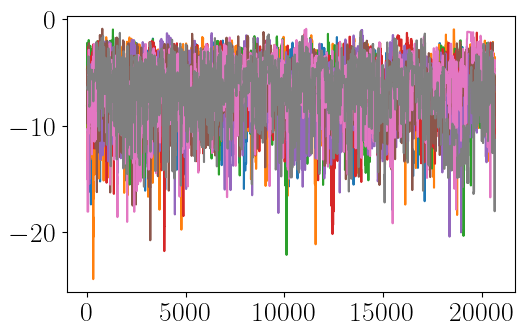

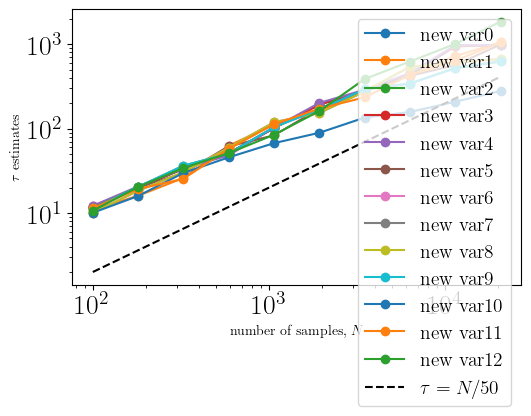

results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.11603108, 0.13079099, 0.12237069, 0.11983485, 0.11466563,
        0.11876199, 0.10553009, 0.11281251, 0.00039013, 0.11872948,
        0.11401541, 0.0863162 , 0.10943139, 0.13079099, 0.11898956,
        0.12045255, 0.12685718, 0.11905459, 0.11284502, 0.12773497,
        0.1236061 , 0.10982152, 0.13524497, 0.11677883, 0.1121948 ,
        0.12188303, 0.13452973, 0.12334601, 0.12162294, 0.12022497,
        0.12763744, 0.12653207]])}}


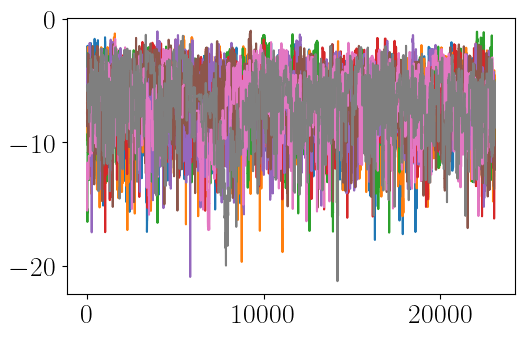

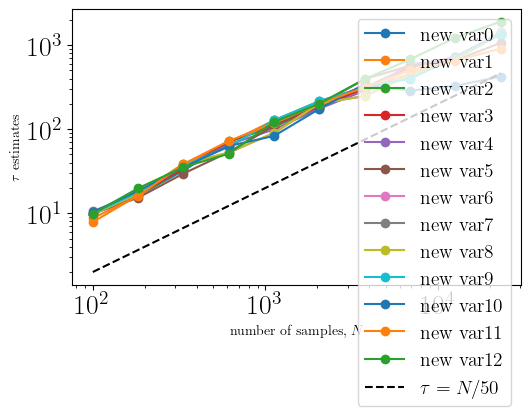

In [43]:
temp=0

samp_final = []
inj_pars = []
for filename,el in zip(datasets,pars_inj):
    file  = HDFBackend(filename)
    print(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.25)
    thin = 1
    ll = file.get_log_like(discard=burn, thin=thin)
    mask = np.arange(8)#[file.get_move_info()['StretchMove_0']['acceptance_fraction'][0]>0.1]
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])
    logl = ll[:,temp,mask,...]

    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp_final.append( np.hstack((samp[inds[:,temp,mask,...]],logl[inds[:,temp,mask,0],None])) )
    inj_pars.append(np.load(el))

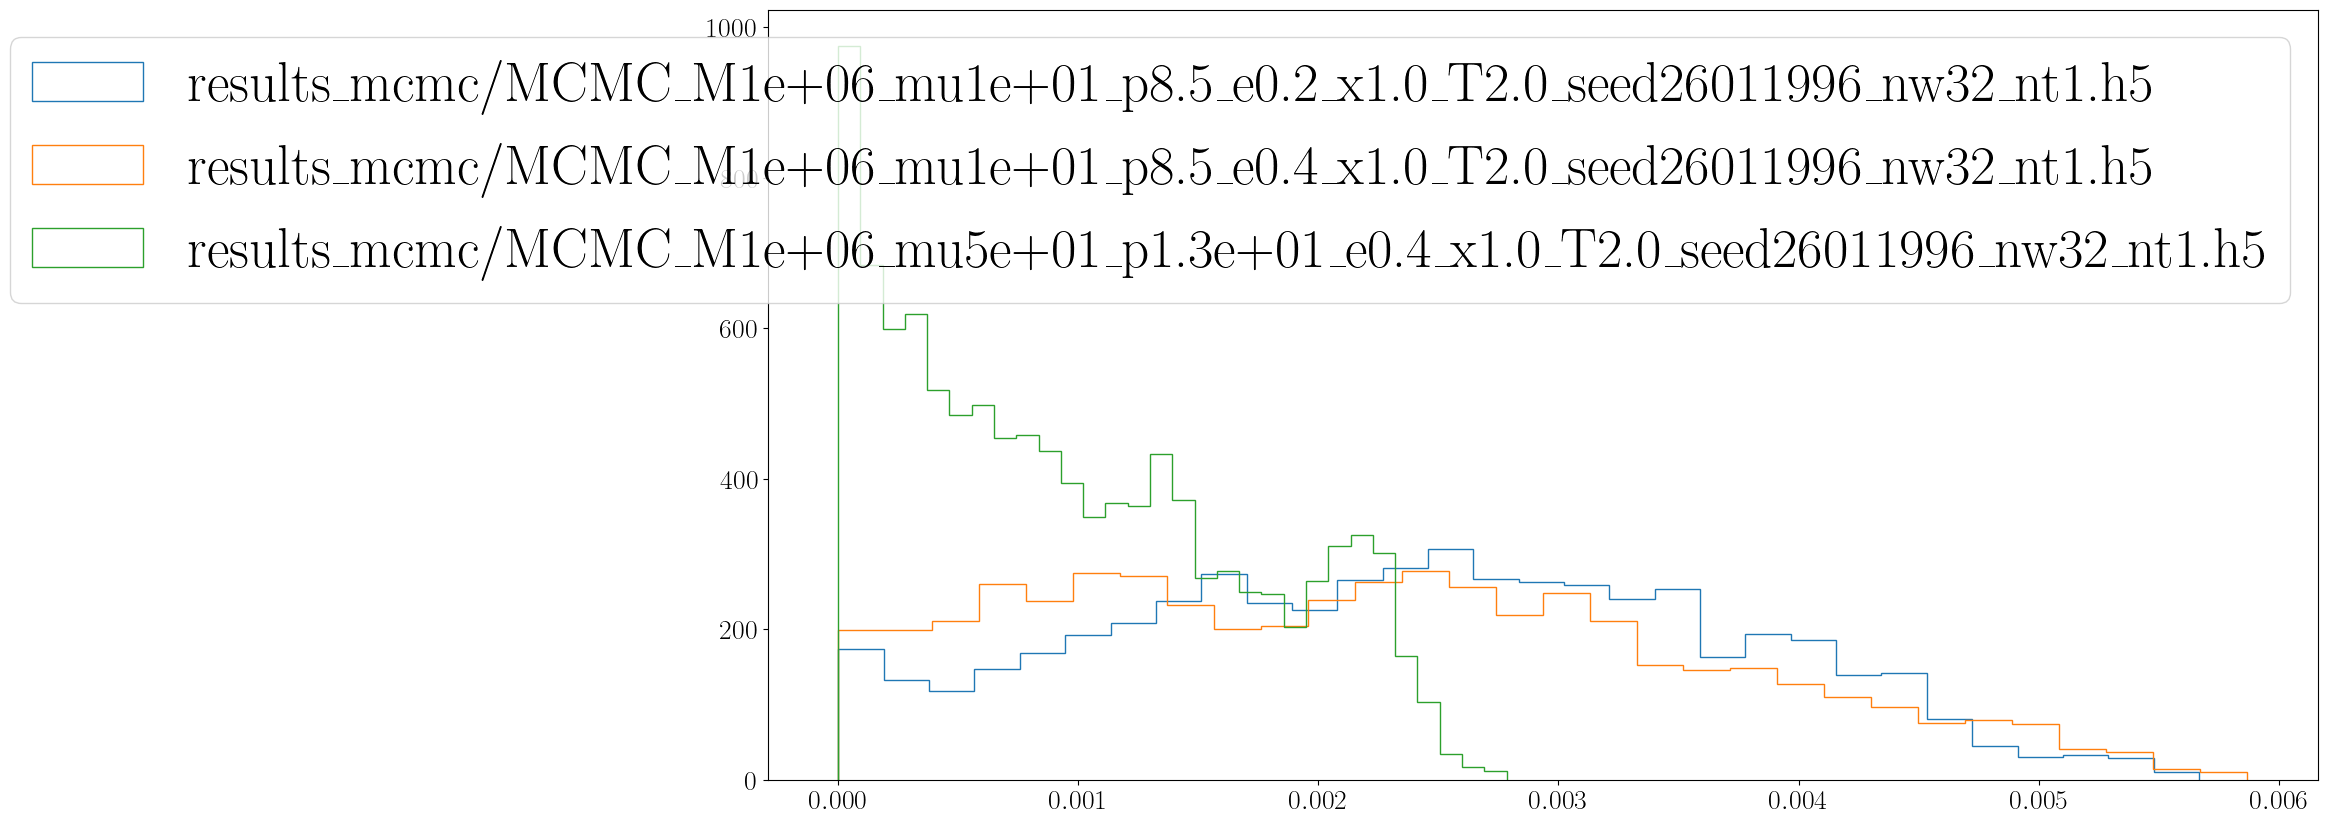

In [63]:
plt.figure(figsize=(20,10))
for el,lab in zip(samp_final,datasets):
    plt.hist(el[:,-2],bins=30,density=True,label=lab, histtype='step')
plt.legend()
plt.show()

In [44]:
mpl.rcParams.update({
    "text.usetex": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "font.family": "serif",
    "figure.figsize": [default_width, default_width * default_ratio],
  'legend.fontsize': 40,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20,
# "axes.formatter.min_exponent": 1
"axes.formatter.offset_threshold": 10
})



In [46]:
truths = inj_pars[0]

CORNER_KWARGS = dict(
#     smooth=0.6,
    labels=[r'$\log (M/{\rm M}_\odot$)', r'$\log (\mu / M)$', r'$a$', r'$p_0 \, [M]$', r'$e_0$', 
            r'$D_L$',
            r"$\cos \theta_S$",r"$\phi_S$",
            r"$\cos \theta_K$",r"$\phi_K$",
           r'$\Phi_{\varphi 0}$', r'$\Phi_{r 0}$',
            r"$d$",
            'log-likelihood'
           ],
    bins=40,
    truths = truths,
    label_kwargs=dict(fontsize=35),
#     title_kwargs=dict(fontsize=13),
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,
    truth_color='k',
    labelpad=0.3,
)
import matplotlib.lines as mlines

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('Set1',)
    colors = [cmap(i) for i in range(n)]#['black','red', 'royalblue']#

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=35, frameon=False,
        bbox_to_anchor=(0.5, ndim+1), 
        loc="upper right"
    )
    
#     fig.subplots_adjust(right=1.0,top=1.0)

    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=None, top=None, wspace=None, hspace=0.15)

    if name_save is not None:
        plt.savefig(name_save+".pdf", pad_inches=0.2, bbox_inches='tight')
    else:
        plt.show()


In [48]:
name_mcmc = [el.split('downsample1_')[-1].split('.h5')[0] for el in datasets]
name_mcmc

['results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.2_x1.0_T2.0_seed26011996_nw32_nt1',
 'results_mcmc/MCMC_M1e+06_mu1e+01_p8.5_e0.4_x1.0_T2.0_seed26011996_nw32_nt1',
 'results_mcmc/MCMC_M1e+06_mu5e+01_p1.3e+01_e0.4_x1.0_T2.0_seed26011996_nw32_nt1']

/tmp/ipykernel_1206382/1987426078.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1',)


ValueError: Provided figure has 196 axes, but data has dimensions K=13

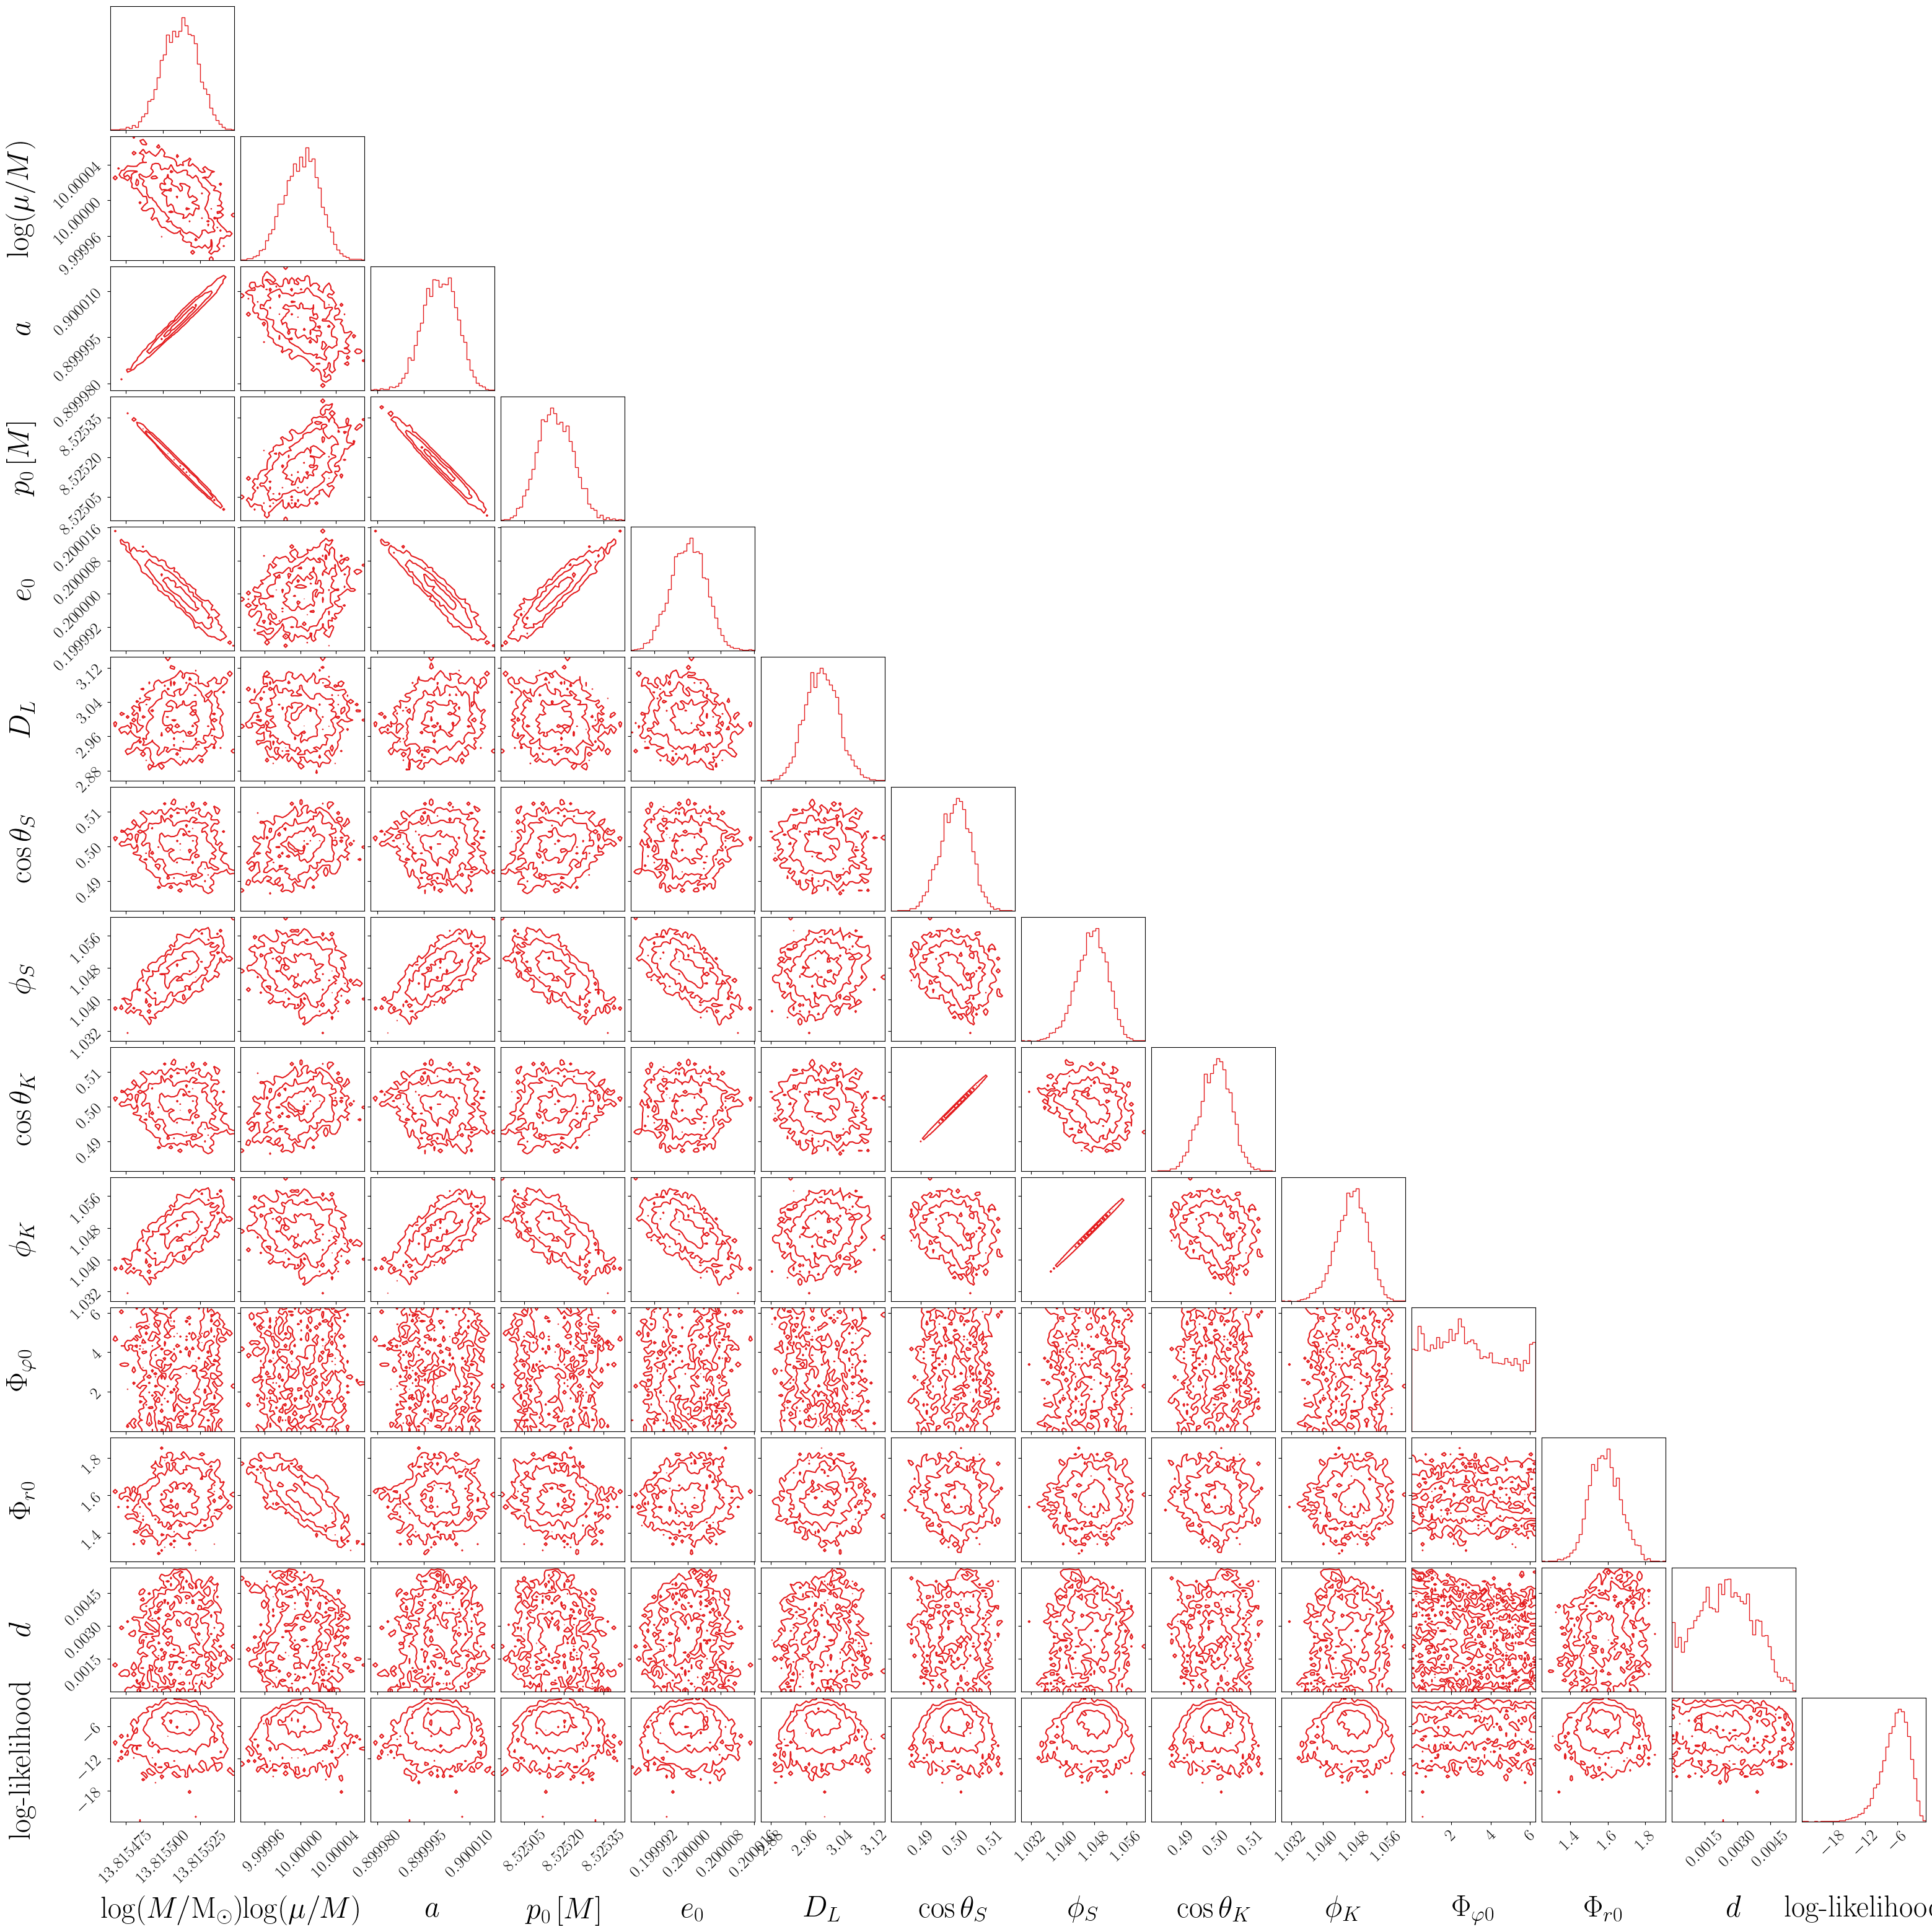

In [54]:
overlaid_corner([samp_final[0]], ["Fiducial"])

In [39]:
from scipy.stats import entropy
set_num = [[0,1],[0,2],[2,1]]
for ii in range(3):
    for var in range(6):
        bins = np.linspace(samp_final[0][:,var].min(),samp_final[0][:,var].max(),num=20)
        counts1,_ = np.histogram(samp_final[set_num[ii][0]][:,var],bins=bins)
        counts2,_ = np.histogram(samp_final[set_num[ii][1]][:,var],bins=bins)
        print(entropy(counts2,qk=counts1))

7.511629491187708e-05
0.00022136145317279798
0.0002133622926115147
0.00012687262007742486
0.00010547404460524276
0.00012788585227911471
0.0003895700901878787
8.259397263103794e-05
6.820638703927235e-05
0.00027832986979116873
9.609976264535623e-05
6.874366367275577e-05
0.0002418487936459391
0.00015093808003734184
0.0001859957684406602
0.00012475519282710554
0.0001129106530749433
0.00011284880805310517


# Downsampled

In [40]:
CORNER_KWARGS

{'labels': ['$\\log (M/{\\rm M}_\\odot$)',
  '$\\log (\\mu / M)$',
  '$p_0 \\, [M]$',
  '$e_0$',
  '$\\Phi_{\\varphi 0}$',
  '$\\Phi_{r 0}$',
  'log-likelihood'],
 'bins': 40,
 'truths': [15.115713592242255,
  -9.438760095027266,
  13.709101864726545,
  0.5794130830706371,
  1.0471975511965976,
  1.0471975511965976,
  0.0],
 'label_kwargs': {'fontsize': 35},
 'levels': (0.3934693402873666, 0.8646647167633873, 0.9888910034617577),
 'plot_density': False,
 'plot_datapoints': False,
 'fill_contours': False,
 'show_titles': False,
 'max_n_ticks': 4,
 'truth_color': 'k',
 'labelpad': 0.3,
 'range': [[15.115687267052175, 15.115739420764386],
  [-9.438829404512905, -9.438693633194458],
  [13.708922936633092, 13.709292113991944],
  [0.5793977942631167, 0.5794294904687305],
  [0.7730447739530297, 1.301019219849867],
  [0.9310958033331248, 1.1544861185232909],
  [-19.591033041293453, -0.02952779622263154]]}

In [41]:
lst = ['solid','dashed','dashdot']
CORNER_KWARGS = dict(
#     smooth=0.6,
    labels=[r'$\log (M/{\rm M}_\odot$)', r'$\log (\mu / M)$', r'$p_0 \, [M]$', r'$e_0$', 
           r'$\Phi_{\varphi 0}$', r'$\Phi_{r 0}$','log-likelihood'
           ],
    bins=40,
    truths = truths,
    label_kwargs=dict(fontsize=35),
#     title_kwargs=dict(fontsize=13),
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=4,
    truth_color='k',
    labelpad=0.3,
)

def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('tab10',)
    colors = [cmap(i) for i in range(n)]#['black','red', 'royalblue']#

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        
        
        CORNER_KWARGS['contour_kwargs'] = {"linestyles":lst[idx],"color":colors[idx],"linewidths":2}
        CORNER_KWARGS['hist_kwargs'] = {"ls":lst[idx],"color":colors[idx]}

        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    leg=plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i],linestyle=lst[i])
            for i in range(n)
        ],
        fontsize=35, frameon=False,
        bbox_to_anchor=(0.5, ndim+1.0), 
        loc="upper right",
        title=r'$(f_{\rm max} \, [\rm{mHz}], N_f,\rm{likelihood} \, \rm{speed} \{\rm{CPU,GPU}\} \,[\rm{s}])=$',
        title_fontsize=35,
    )

    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=None, top=None, wspace=None, hspace=0.15)

    if name_save is not None:
        plt.savefig(name_save+".pdf", pad_inches=0.2, bbox_inches='tight')
    else:
        plt.show()



In [42]:
datasets = sorted(glob.glob('results/downsampled_mcmc/*.h5'))+ glob.glob('results/MCMC_*window_flagFalse*.h5')
datasets
downsample_value = np.asarray([datasets[ii].split('_downsample')[1].split('_inject')[0] for ii in range(len(datasets))],dtype=int)
datasets = [datasets[ii] for ii in np.argsort(downsample_value)]
datasets

['results/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt1_downsample0_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5',
 'results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample1_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5',
 'results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample10_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5',
 'results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample100_injectFD1_usegpuFalse_templatefd_window_flagFalse.h5',
 'results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample1000_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5',
 'results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample10000_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5']

results/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt1_downsample0_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.40970007, 0.41007648, 0.4101183 , 0.41065304, 0.41119376,
        0.40929677, 0.40924897, 0.41081138, 0.41074565, 0.4118241 ,
        0.40965824, 0.4108771 , 0.4094073 , 0.41003465, 0.4109249 ,
        0.41003764, 0.41153731, 0.40991217, 0.41086216, 0.40987632,
        0.40914142, 0.41128338, 0.41001075, 0.40929378, 0.40811973,
        0.41033339, 0.41082333, 0.41015116, 0.41031248, 0.41046783,
        0.41093983, 0.40933262]])}}


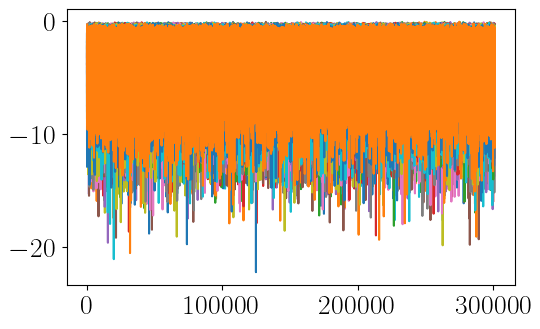

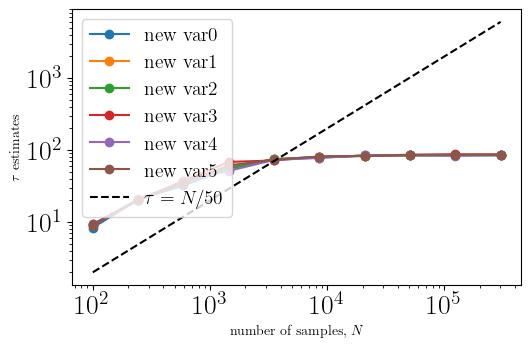

results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample1_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.40845315, 0.41289304, 0.41015279, 0.41696873, 0.41193916,
        0.41336131, 0.41245946, 0.41053435, 0.40928563, 0.4087133 ,
        0.41029154, 0.40916422, 0.41001405, 0.40926828, 0.40907751,
        0.41070778, 0.40909485, 0.40952843, 0.41561595, 0.41254618,
        0.40692693, 0.40925094, 0.40838377, 0.40588633, 0.40708302,
        0.40798488, 0.41145355, 0.41032623, 0.41601485, 0.4123554 ,
        0.41077716, 0.41056904],
       [0.26337606, 0.26811079, 0.26238749, 0.26108673, 0.26035831,
        0.26476352, 0.26429525, 0.26295982, 0.26342809, 0.26665395,
        0.26384433, 0.26648051, 0.26245686, 0.26514508, 0.26341074,
        0.26464212, 0.2640351 , 0.26594287, 0.26346277, 0.26294247,
        0.26382698, 0.26306388, 0.257514  , 0.26374027, 0.26570006,
        0.26044

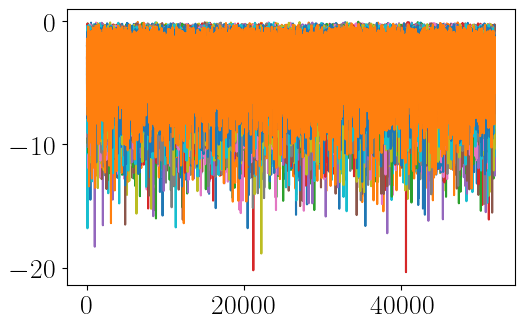

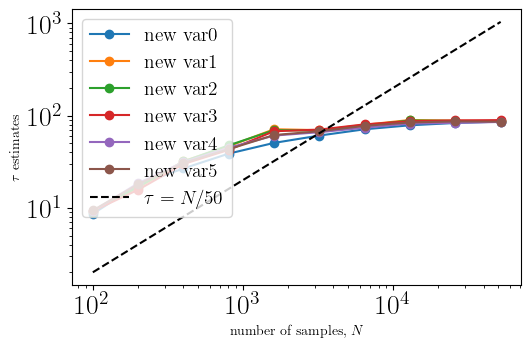

results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample10_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.40123491, 0.39939143, 0.39772563, 0.40056859, 0.40248981,
        0.40083512, 0.40290071, 0.40424445, 0.40066854, 0.40209002,
        0.40417782, 0.39976901, 0.39821427, 0.40176797, 0.40376692,
        0.40067965, 0.40228992, 0.40156807, 0.40673204, 0.40161249,
        0.39928038, 0.40124602, 0.40256755, 0.40203449, 0.39968017,
        0.40186791, 0.39980233, 0.40077959, 0.4051773 , 0.40027985,
        0.40306729, 0.40295623],
       [0.26140793, 0.26610548, 0.26286273, 0.26075272, 0.2609304 ,
        0.26256288, 0.26380668, 0.26024187, 0.26631648, 0.26479505,
        0.26232967, 0.2628072 , 0.26276278, 0.26157451, 0.26380668,
        0.2632181 , 0.26327362, 0.26693838, 0.26680511, 0.26166335,
        0.26576121, 0.26360678, 0.25846502, 0.26231857, 0.26298489,
        0.2602

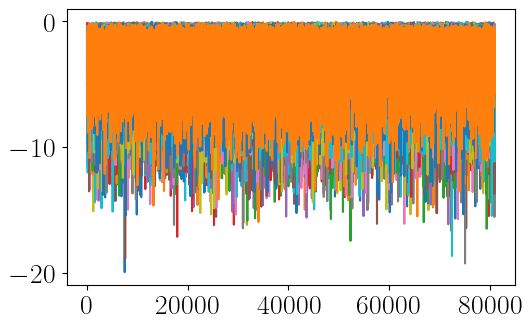

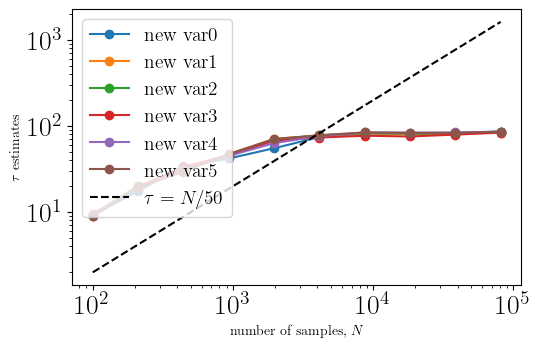

results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample100_injectFD1_usegpuFalse_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.46588883, 0.46780497, 0.46404857, 0.46901916, 0.46956934,
        0.46583191, 0.46755834, 0.46600266, 0.46900019, 0.46304307,
        0.4702713 , 0.47104914, 0.46674255, 0.46985392, 0.46748245,
        0.46317587, 0.46858281, 0.46583191, 0.47011952, 0.46755834,
        0.46725479, 0.4670461 , 0.46994878, 0.46585088, 0.46826029,
        0.46562322, 0.46736862, 0.46987289, 0.46970214, 0.46960729,
        0.46867767, 0.46970214],
       [0.26319484, 0.26721685, 0.26110795, 0.26143047, 0.26044394,
        0.26475052, 0.26573705, 0.26224625, 0.26374502, 0.26744451,
        0.26359325, 0.26687536, 0.26156327, 0.26511098, 0.26397268,
        0.26494024, 0.26408651, 0.26605957, 0.26499715, 0.26298615,
        0.26431417, 0.26338456, 0.25750332, 0.26431417, 0.26638209,
        0.26

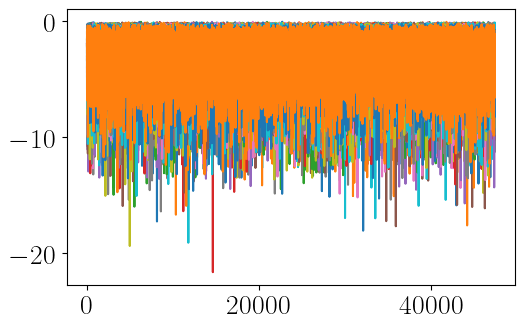

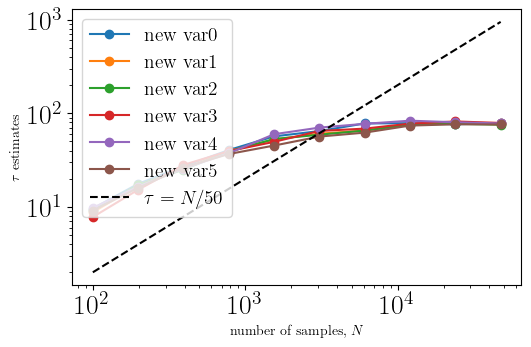

results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample1000_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.5057735 , 0.50975204, 0.50558845, 0.5069208 , 0.50797557,
        0.50673575, 0.50817913, 0.50780903, 0.51054774, 0.50523686,
        0.50673575, 0.50856773, 0.50592154, 0.50777202, 0.50529238,
        0.50351591, 0.50969652, 0.50534789, 0.51117691, 0.50771651,
        0.50427461, 0.50723538, 0.50721688, 0.50518135, 0.50412657,
        0.50568098, 0.50938194, 0.51058475, 0.50980755, 0.51043671,
        0.50910437, 0.5080681 ],
       [0.26326795, 0.26767209, 0.26186158, 0.26149149, 0.25993708,
        0.26478534, 0.26517395, 0.26260178, 0.26410067, 0.26674685,
        0.26393412, 0.26685788, 0.26123242, 0.26524796, 0.26397113,
        0.26493338, 0.26367506, 0.26633975, 0.26448927, 0.26332346,
        0.26432272, 0.26321244, 0.2580866 , 0.26400814, 0.26550703,
        0.26

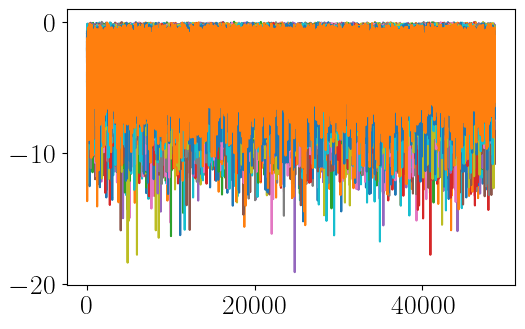

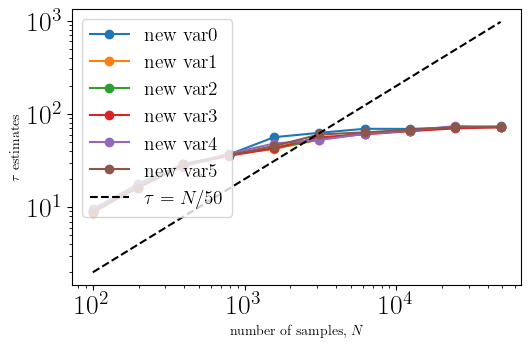

results/downsampled_mcmc/MCMC_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt2_downsample10000_injectFD1_usegpuTrue_templatefd_window_flagFalse.h5
{'StretchMove_0': {'acceptance_fraction': array([[0.51068695, 0.51638543, 0.51503919, 0.51540802, 0.51669894,
        0.51487321, 0.51662517, 0.51271554, 0.51762102, 0.51026279,
        0.51728907, 0.51448594, 0.51195943, 0.51610881, 0.51188566,
        0.51284463, 0.51706777, 0.51465191, 0.52145689, 0.51472568,
        0.51171969, 0.51457815, 0.51603504, 0.51112955, 0.51684647,
        0.51166436, 0.51780544, 0.51621946, 0.5215491 , 0.5182296 ,
        0.51531581, 0.51701245],
       [0.26441678, 0.26841863, 0.26174274, 0.26045182, 0.26319963,
        0.26419548, 0.26539419, 0.26321807, 0.26567082, 0.2668142 ,
        0.26248041, 0.26439834, 0.2621669 , 0.26502536, 0.26377132,
        0.26661134, 0.26410327, 0.26522822, 0.26596588, 0.26231443,
        0.26502536, 0.26137391, 0.25626556, 0.26316275, 0.26651913,
        0.2

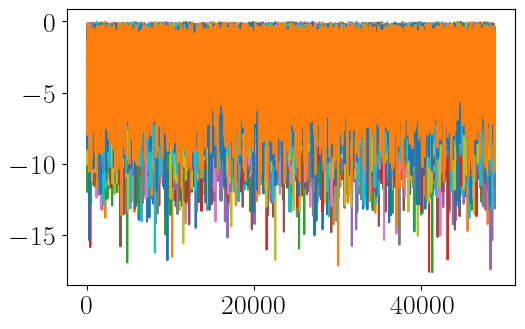

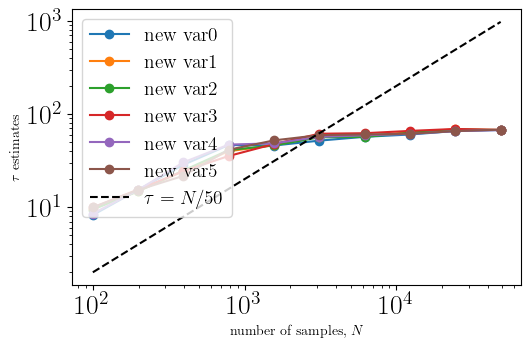

In [43]:
# filename = 'emri_M1e+06_mu1e+01_p9.5_e0.35_T1.0_eps1e-05_seed2601996_injectFD1_templatefd.h5'
temp=0

samp_final_ds = []
for filename in datasets:
    file  = HDFBackend(filename)
    print(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.1)
    thin = 1
    ll = file.get_log_like(discard=burn, thin=thin)
    mask = np.arange(32)#[file.get_move_info()['StretchMove_0']['acceptance_fraction'][0]>0.1]
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])
    logl = ll[:,temp,mask,...]



    samp_final_ds.append( np.hstack((samp[inds[:,temp,mask,...]],logl[inds[:,temp,mask,0],None])) )

In [44]:
name_ds = [f'Downsampling factor '+ datasets[ii].split('_downsample')[1].split('_inject')[0] for ii in range(len(datasets))]
name_ds

['Downsampling factor 0',
 'Downsampling factor 1',
 'Downsampling factor 10',
 'Downsampling factor 100',
 'Downsampling factor 1000',
 'Downsampling factor 10000']

In [45]:
name_ds[0]=r'$(50,6311631,\{4.26, 0.061\})$'
# name_ds[1]=r'$f_{\rm max}=6.3$ mHz with $N_f=3.55443  \times 10^{5}$, CPU likelihood speed = $2.3$ s'
# name_ds[2]=r'$f_{\rm max}=6.3$ mHz with $N_f=3.5544  \times 10^{4}$, CPU likelihood speed = $0.55$ s'
name_ds[3]=r'$(2.8,3554,\{0.34, 0.029\})$'
name_ds[5]=r'$(2.8,35,\{0.32,0.029\})$'

In [46]:
6311631/2

3155815.5

In [47]:
ind = np.asarray([0,3,5])

/data/lsperi/miniconda3/envs/fd_env/lib/python3.7/site-packages/corner/core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


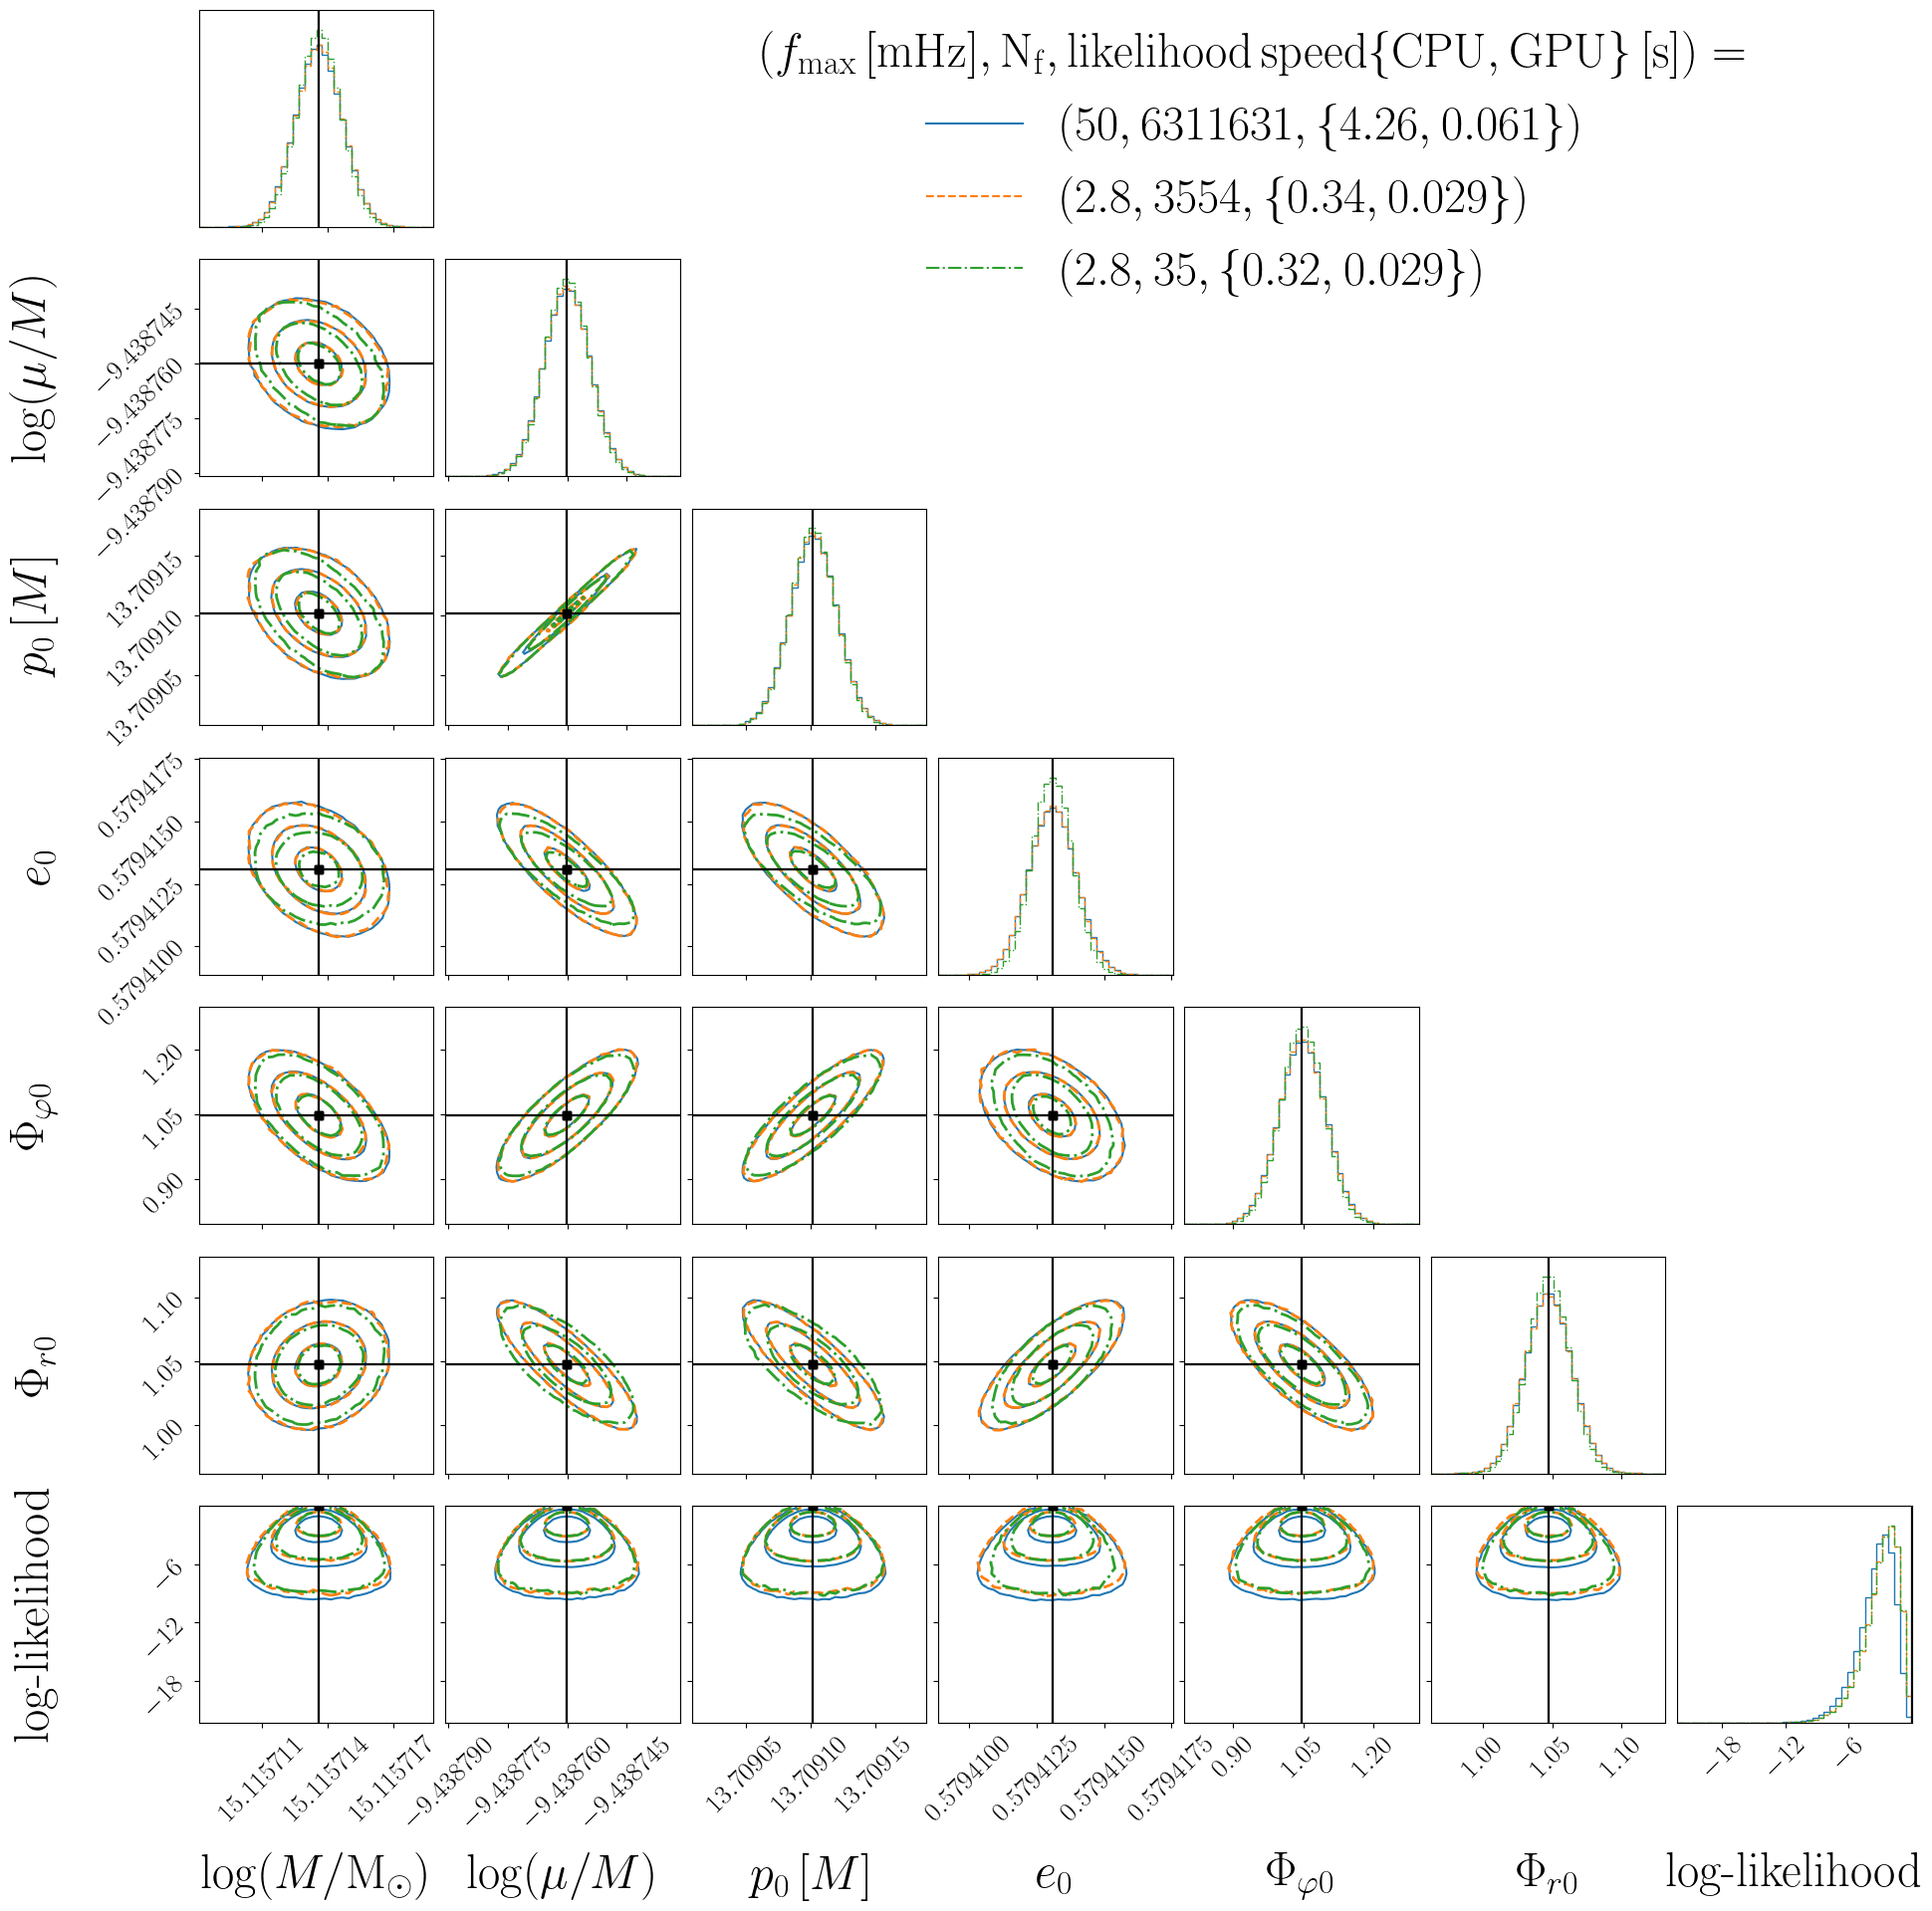

In [48]:
overlaid_corner([samp_final_ds[el] for el in ind], [name_ds[el] for el in ind], name_save='figures/downsampling_posterior_comparison_intrinsic')


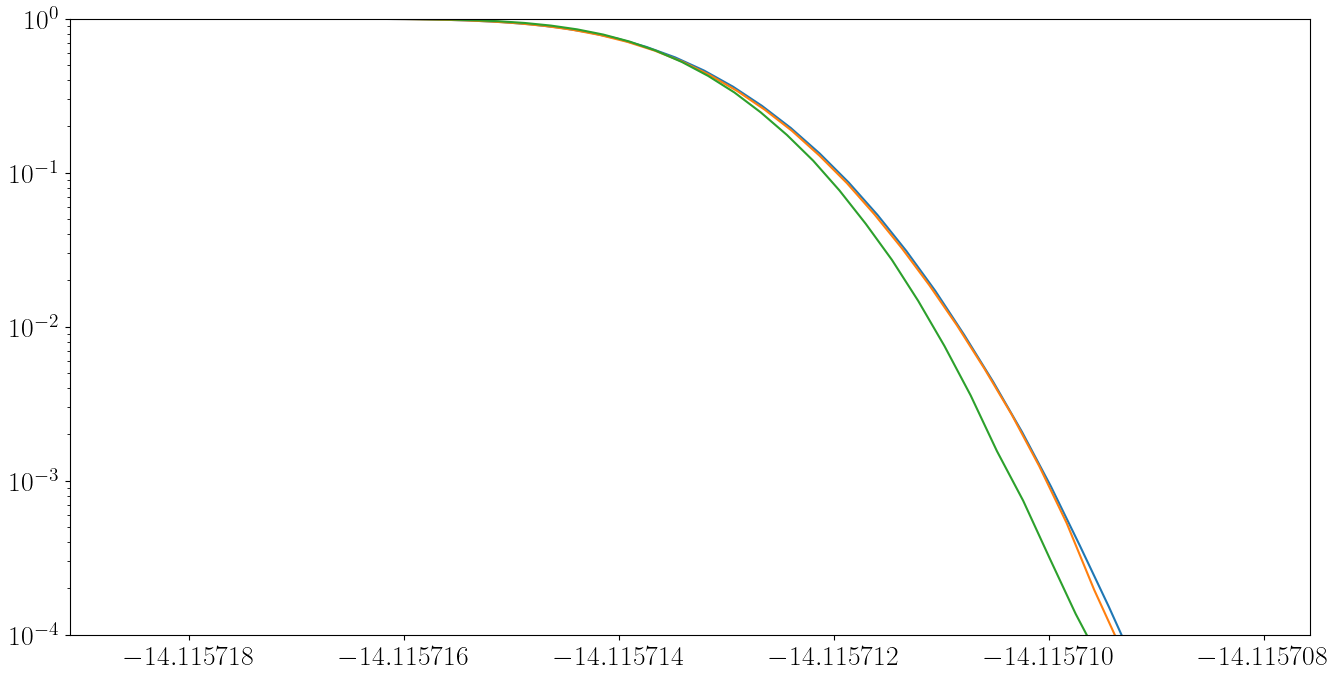

In [49]:
plt.figure(figsize=(16,8))
for el in [samp_final_ds[el] for el in ind]:
    # some fake data
    data = el[:,0]
    # evaluate the histogram
    values, base = np.histogram(data, bins=40, density=True)
    #evaluate the cumulative
    cumulative = np.cumsum(values)/np.sum(values)
    # plot the cumulative function
    plt.semilogy(1-base[:-1], cumulative)

plt.ylim(1e-4,1)
plt.show()

In [50]:
from scipy.stats import entropy
set_num = [[0,ii] for ii in range(1,len(samp_final_ds))]
for ii in range(len(set_num)):
    print('----------------------')
    print("set", name_ds[ii+1])
    for var in range(6):
        bins = np.linspace(samp_final[0][:,var].min(),samp_final[0][:,var].max(),num=20)
        counts1,_ = np.histogram(samp_final_ds[set_num[ii][0]][:,var],bins=bins)
        counts2,_ = np.histogram(samp_final_ds[set_num[ii][1]][:,var],bins=bins)
        print(entropy(counts2,qk=counts1))

----------------------
set Downsampling factor 1
0.00023796002057560898
9.841256959433918e-05
0.00016980074092120385
inf
0.00030432489827367606
inf
----------------------
set Downsampling factor 10
5.325679443848244e-06
inf
inf
6.94263739468735e-05
5.257522231821408e-05
9.995924752156836e-05
----------------------
set $(2.8,3554,\{0.34, 0.029\})$
4.324902052224209e-05
0.00010395933631267328
0.00014645790103987597
2.9483372204979066e-05
0.00011441992234895251
6.404528417620709e-05
----------------------
set Downsampling factor 1000
9.219501564009845e-05
0.002655723565545793
0.0016091184948220632
0.005290266151157734
7.995085702917456e-05
0.0004713484434050297
----------------------
set $(2.8,35,\{0.32,0.029\})$
0.0036553648406397504
0.0015790483717335081
0.0009637182627011279
0.017506185090799934
0.005448438358412908
0.007385915369865548


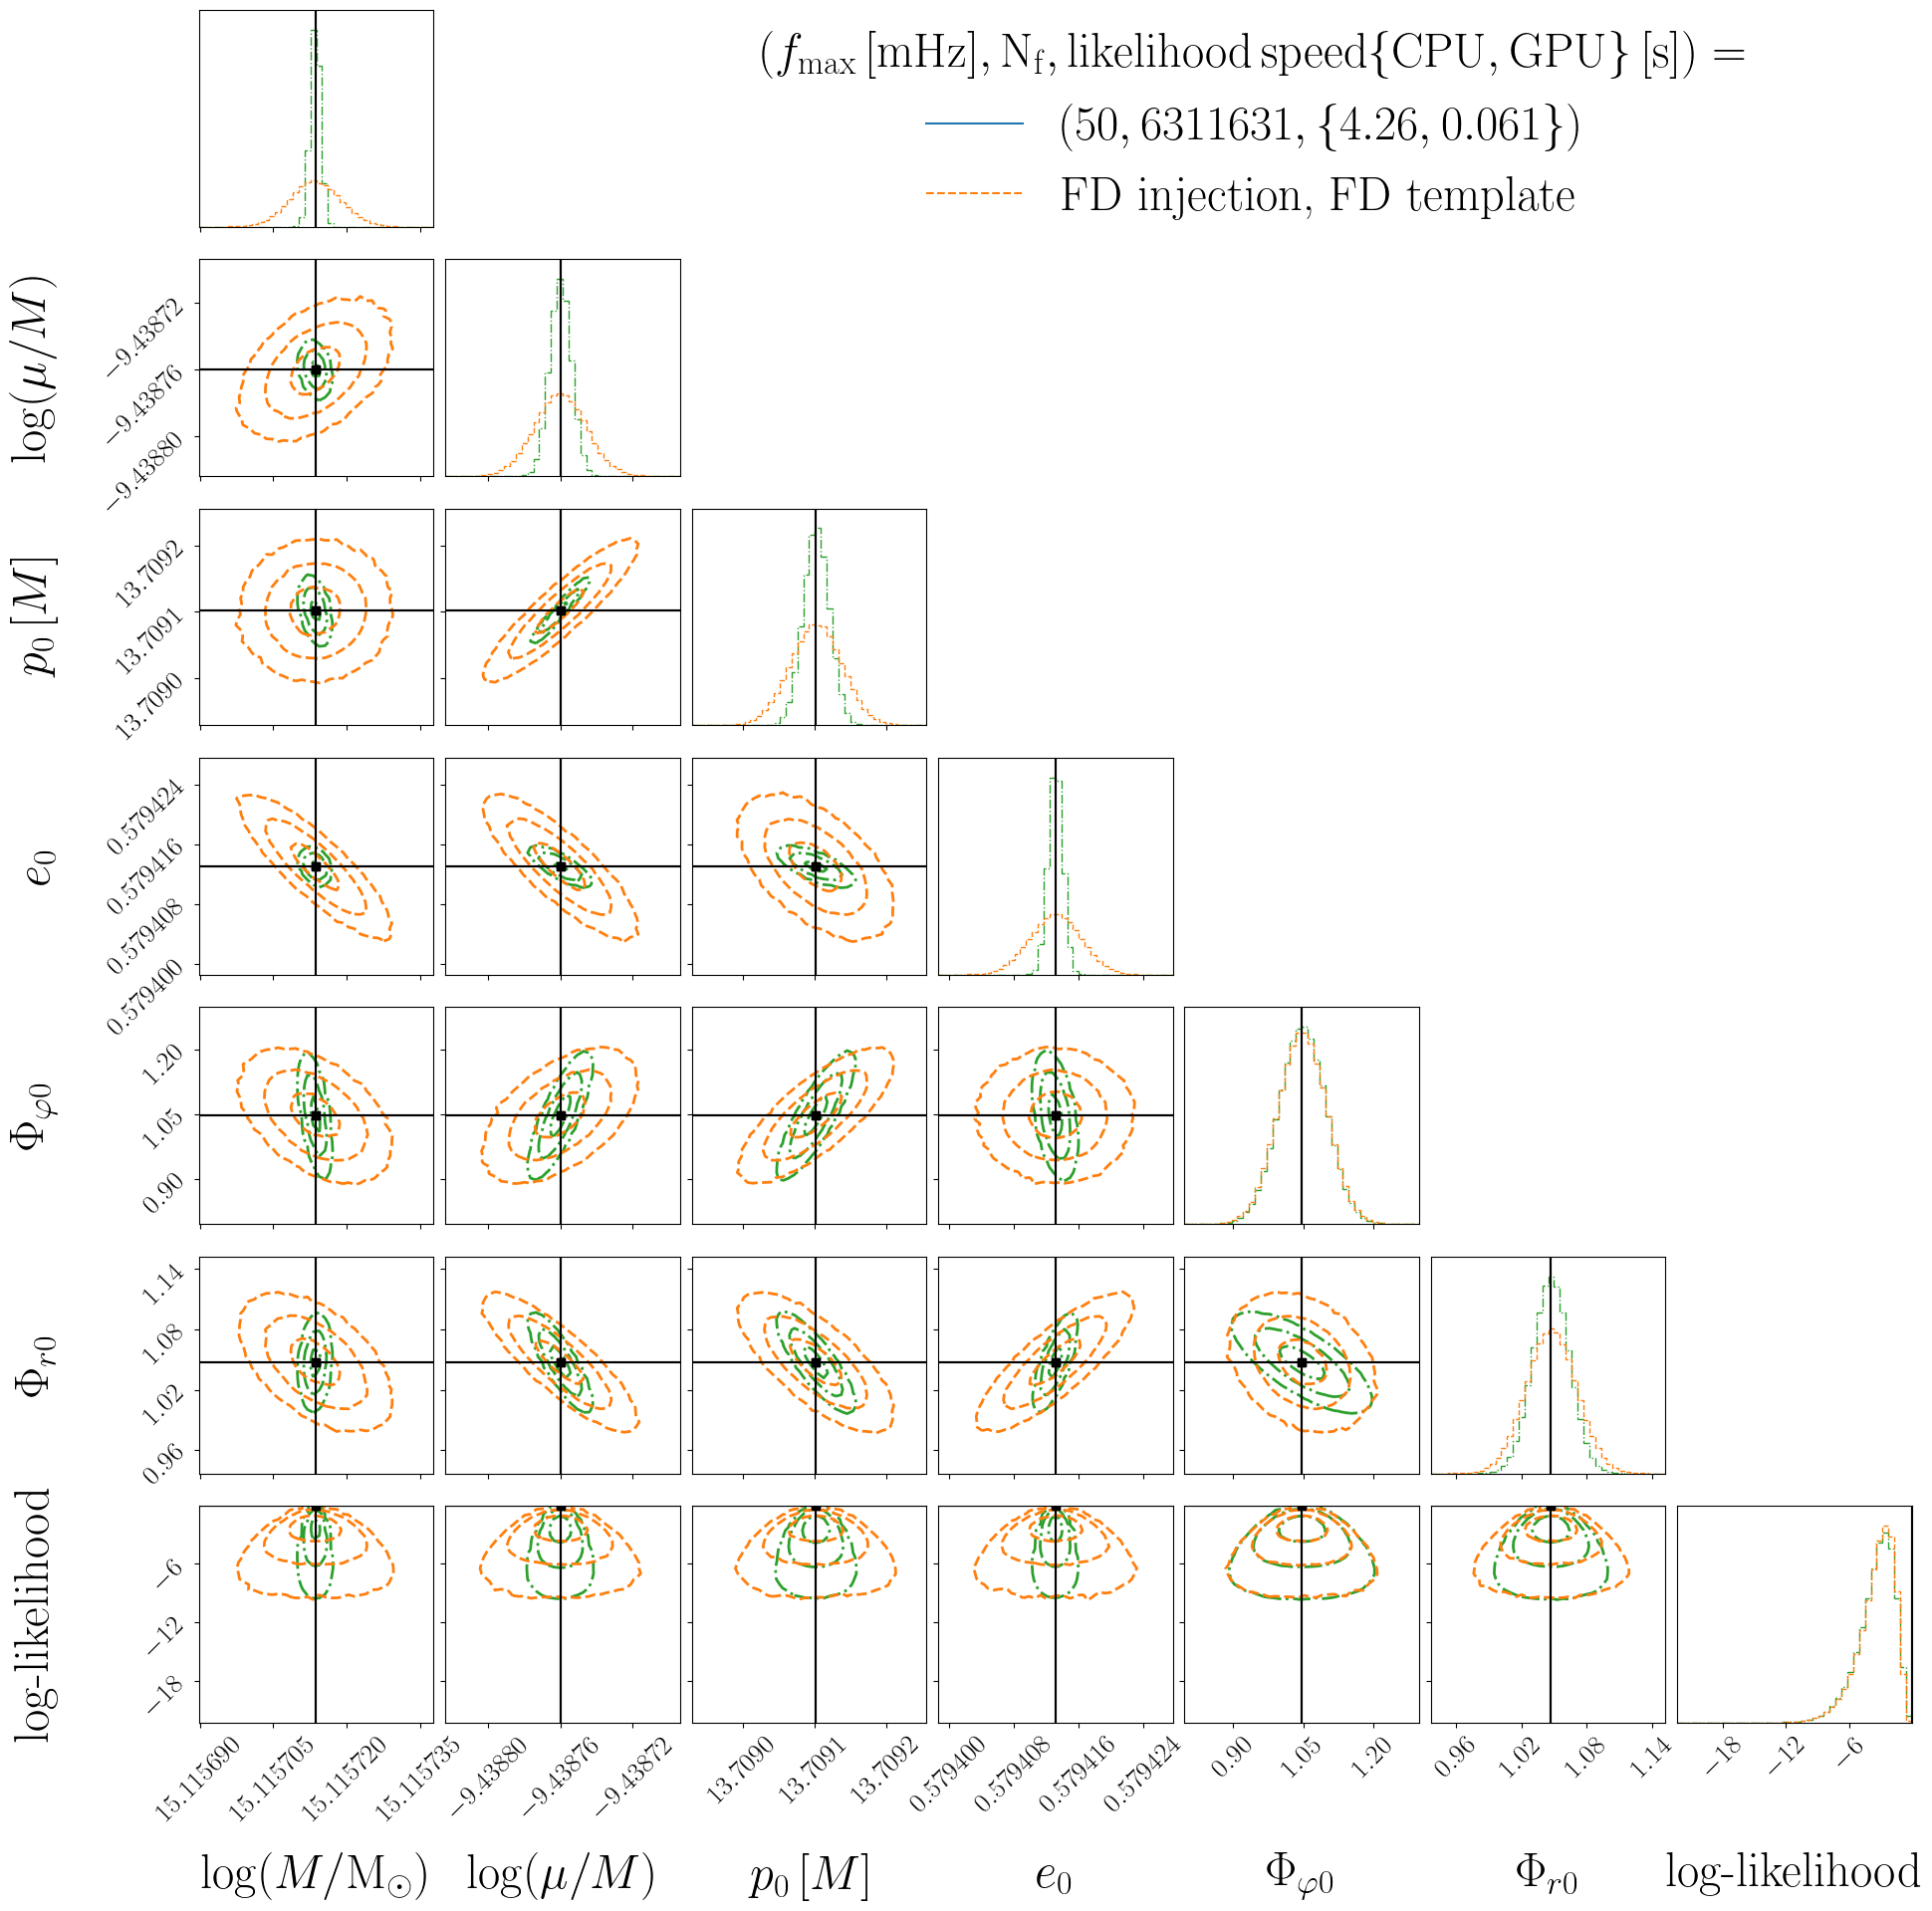

In [51]:
overlaid_corner([samp_final_ds[0],samp_final[2]],
                [name_ds[0],name_mcmc[2]]
               )

In [52]:
for ii in range(7):
    print(np.std(samp_final[0][:,ii]) / np.std(samp_final_ds[0][:,ii]))

4.870860099476719
2.428448969445232
1.9802361128257857
3.6429631977982795
1.037062119977268
1.3704079306364105
0.9760932161688094
